In [1]:
import pandas as pd 
import torch 
import monai
import os
import pickle
from monai.engines import EnsembleEvaluator

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
path = "/data/kaplinsp/models/log_DenseNet121_2025-04-15_22.17.11.log-fixedsize-no-resample-0/"
model = monai.networks.nets.densenet121(
                dropout_prob=0.4, spatial_dims=3, in_channels=1, out_channels=2
            )
model = model.to(0)

In [3]:
model.load_state_dict(torch.load(os.path.join(path, "best_loss_model.pth"))["model_state_dict"])

/tmp/ipykernel_2866997/2537844734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path, "best_loss_model.pth"))["model_stat

<All keys matched successfully>

In [3]:
from datasets import getNoduleInfoList
with open(os.path.join(path, "test.pkl"), 'rb') as f:
    val_ids = pickle.load(f)
nodules = getNoduleInfoList(['sclc'])
nodules = [nod for nod in nodules if (nod.file_path, nod.center_lps) in val_ids]
print(len(nodules))

25


In [55]:
from datasets import NoduleDataset
dataset = NoduleDataset(nodules, 
            isValSet_bool=True,
            dilate=20,
            resample=[64, 64, 64],
            box_size=[65, 65, 80],
            fixed_size=True
            )

from torch.utils.data import DataLoader
val_dl = DataLoader(
            dataset,
            batch_size=16,
            num_workers=4,
            pin_memory=True,
            drop_last=False,
            shuffle=True,
        )

2025-04-16 22:16:09,773 INFO     pid:2868421 datasets:211:__init__ <datasets.NoduleDataset object at 0x7fb3b49f09d0>: 25 validation samples


In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you already have a model and a dataloader
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(0)
        labels = labels.to(0)

        outputs = model(inputs)  # Shape: (batch_size, num_classes) or (batch_size,)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # For binary classification
        # If you're using nn.Sigmoid as the final layer, you don't need to apply it again

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

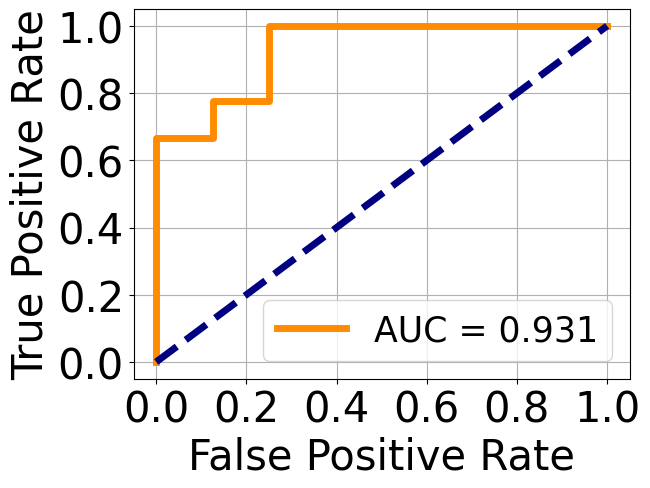

In [8]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=5, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlabel('False Positive Rate', fontdict={"size": 30})
plt.ylabel('True Positive Rate',fontdict={"size": 30})
plt.legend(loc="lower right", fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.show()

In [62]:
import os
import torch
import monai
from concurrent.futures import ThreadPoolExecutor

def load_model(fold_index):
    device = torch.device(fold_index % torch.cuda.device_count())
    path = f"/data/kaplinsp/models/log_DenseNet121_2025-04-15_22.17.11.log-fixedsize-no-resample-{fold_index}"
    model = monai.networks.nets.densenet121(
        dropout_prob=0.4, spatial_dims=3, in_channels=1, out_channels=2
    ).to(device)
    model.load_state_dict(torch.load(os.path.join(path, "best_loss_model.pth"))["model_state_dict"])
    model.eval()
    return model, device

def get_all_models_parallel(fold_indices):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(load_model, fold_indices))
    models, devices = zip(*results)
    return models, devices

networks, devices = get_all_models_parallel([0,4])

/tmp/ipykernel_2868421/1526023824.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path, "best_loss_model.pth"))["model_sta

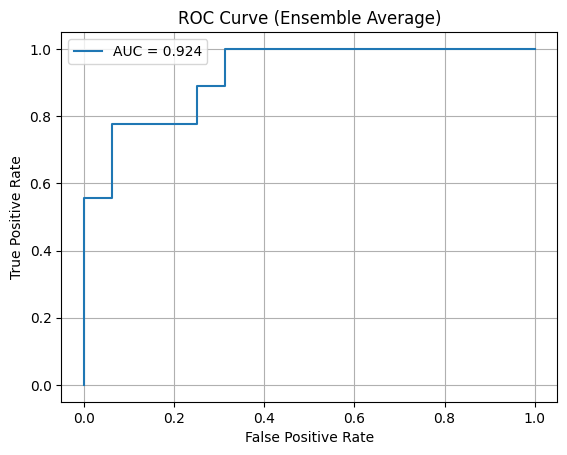

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Set all models to eval mode
for model in networks:
    model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dl:
        # inputs = inputs.to(0)

        # Get predictions from each model and average them
        batch_probs = []
        for model, device in zip(networks, devices):
            inputs = inputs.to(device)
            
            outputs = model(inputs)  # Shape: (batch_size, num_classes)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
            batch_probs.append(probs.to(0))

        # Stack and average the predictions across models
        avg_probs = torch.stack(batch_probs, dim=0).mean(dim=0)

        all_probs.append(avg_probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Optional: plot ROC
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Ensemble Average)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
len(networks)

4

In [17]:
evaluator = EnsembleEvaluator(device=0,val_data_loader=val_dl, networks=networks)
evaluator.run()

In [ ]:
evaluator.

False

In [46]:
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# 2. Find the optimal threshold (closest to point (0,1))
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")

# Binarize predictions at the optimal threshold
binary_preds = (all_probs >= optimal_threshold).astype(int)

# Compute metrics
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
acc = accuracy_score(all_labels, binary_preds)
specificity = precision_score(all_labels, binary_preds)

print(f"Sensitivity:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Specificity: {precision:.4f}")

Optimal threshold (Youden's J): 0.5145
Sensitivity:    0.7778
F1 Score:  0.8235
Accuracy: 0.8800
Specificity: 0.8750


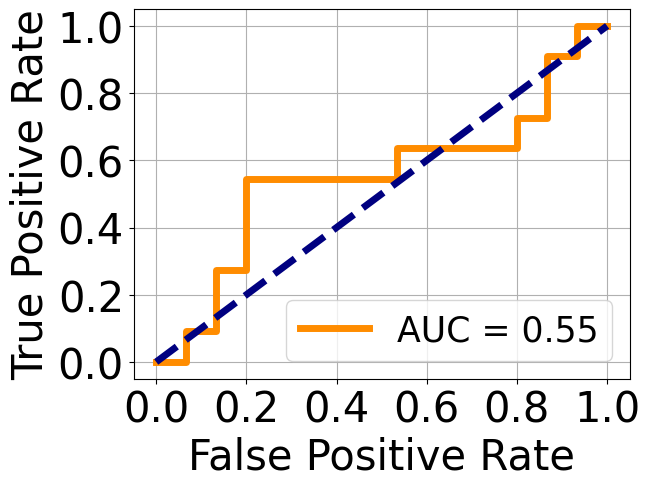

In [9]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=5, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlabel('False Positive Rate', fontdict={"size": 30})
plt.ylabel('True Positive Rate',fontdict={"size": 30})
plt.legend(loc="lower right", fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.show()

In [47]:
from image import NoduleInfoTuple, NRRDNodule
coord_file = "/home/kaplinsp/ct_lung_class/annotations-sclc.csv"

exclude_paths = ["/data/kaplinsp/transformation/A114.nrrd"]
coord_df = pd.read_csv(coord_file, index_col=False)

coord_df = coord_df[(coord_df["label"] == 2) & (~coord_df["path"].isin(exclude_paths))]

transformed = list(
    coord_df.apply(
        lambda row: NoduleInfoTuple(
            row["label"],
            row["path"],
            (row["x"], row["y"], row["z"]),
            row["path"],
            NRRDNodule,
        ),
        axis=1,
    ).to_numpy()
)

[NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(73.54381040198675, -0.8343828483444327, -51.875), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(79.71864839933772, 71.49943369205295, -85.625), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(107.94647924437083, -22.00525598211925, -126.875), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(96.0378631066225, 10.633173432450292, -121.875), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_no

In [48]:
from datasets import NoduleDataset
dataset = NoduleDataset(transformed, 
            isValSet_bool=True,
            dilate=20,
            resample=[64, 64, 64],
            box_size=[65, 65, 80],
            fixed_size=True
            )

from torch.utils.data import DataLoader
val_dl = DataLoader(
            dataset,
            batch_size=16,
            num_workers=4,
            pin_memory=True,
            drop_last=False,
            shuffle=True,
        )

2025-04-16 22:13:07,736 INFO     pid:2868421 datasets:211:__init__ <datasets.NoduleDataset object at 0x7fb3b43e8040>: 18 validation samples


In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you already have a model and a dataloader
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(0)
        labels = torch.ones(inputs.shape[0]).to(0)

        outputs = model(inputs)  # Shape: (batch_size, num_classes) or (batch_size,)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # For binary classification
        # If you're using nn.Sigmoid as the final layer, you don't need to apply it again

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

2025-04-16 22:13:12,873 INFO     pid:2871845 datasets:093:get_fixed_size_nodule Slicing nodule from image for /data/kaplinsp/transformation/T462655SB.nrrd
2025-04-16 22:13:12,874 INFO     pid:2871846 datasets:093:get_fixed_size_nodule Slicing nodule from image for /data/kaplinsp/transformation/T462661AB.nrrd
2025-04-16 22:13:13,658 INFO     pid:2871846 datasets:093:get_fixed_size_nodule Slicing nodule from image for /data/kaplinsp/transformation/T462678AC.nrrd
2025-04-16 22:13:13,937 INFO     pid:2871845 datasets:093:get_fixed_size_nodule Slicing nodule from image for /data/kaplinsp/transformation/T462663SB.nrrd
2025-04-16 22:13:14,832 INFO     pid:2871845 datasets:093:get_fixed_size_nodule Slicing nodule from image for /data/kaplinsp/transformation/T462679AB.nrrd
2025-04-16 22:13:15,856 INFO     pid:2871845 datasets:093:get_fixed_size_nodule Slicing nodule from image for /data/kaplinsp/transformation/T462655SB.nrrd
2025-04-16 22:13:16,897 INFO     pid:2871845 datasets:093:get_fixed_si

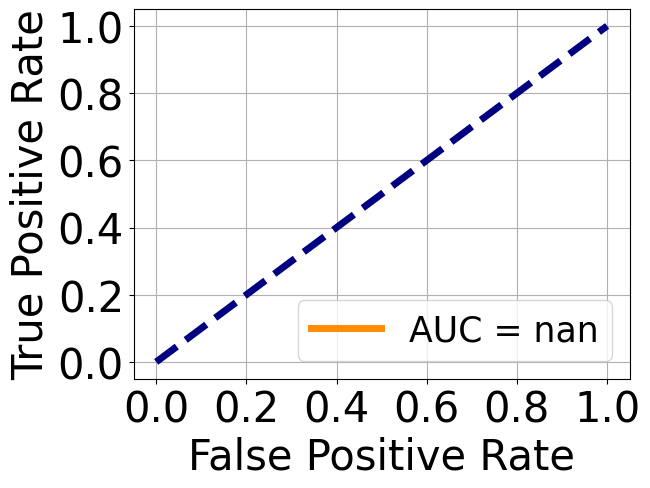

In [58]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=5, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlabel('False Positive Rate', fontdict={"size": 30})
plt.ylabel('True Positive Rate',fontdict={"size": 30})
plt.legend(loc="lower right", fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.show()

In [50]:
cutoff = 0.5145  # replace with your actual cutoff
pred_labels = (all_probs >= cutoff).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(all_labels, pred_labels))
print(classification_report(all_labels, pred_labels))

[[ 0  0]
 [13  5]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.28      0.43        18

    accuracy                           0.28        18
   macro avg       0.50      0.14      0.22        18
weighted avg       1.00      0.28      0.43        18



/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
all_probs

array([0.15264763, 0.15202478, 0.14597091, 0.06228953, 0.19322033,
       0.19923164, 0.07629574, 0.24558626, 0.08124487, 0.41956678,
       0.29949504, 0.10220089, 0.22916304, 0.18114053, 0.24580091,
       0.13981824, 0.13616623, 0.27401027], dtype=float32)